In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import faiss
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import re
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.utils import resample
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack, csr_matrix
from scipy.stats import uniform, randint


In [12]:
data = pd.read_csv('Datasets/balanced_data.csv')

In [13]:
data.columns

Index(['Label', 'Preprocessed_Content', 'sentiment', 'hate_speech_count',
       'pos_tags', 'word2vec', 'sbert_embedding', 'lexical_diversity',
       'sentence_complexity'],
      dtype='object')

In [14]:
len(data)

60000

In [15]:
data['Label'].value_counts()

Label
0    30000
1    30000
Name: count, dtype: int64

In [16]:
from sklearn.utils import resample

class_0 = data[data['Label'] == 0]
class_1 = data[data['Label'] == 1]

class_0_sampled = resample(class_0, n_samples=10000, random_state=42)
class_1_sampled = resample(class_1, n_samples=10000, random_state=42)

balanced_data = pd.concat([class_0_sampled, class_1_sampled])

balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

print(balanced_data['Label'].value_counts())


Label
1    10000
0    10000
Name: count, dtype: int64


In [19]:
train_data = balanced_data

In [20]:
def convert_embedding(embedding):
    if isinstance(embedding, np.ndarray):
        return embedding
    elif isinstance(embedding, list):
        return np.array(embedding, dtype=np.float32)
    elif isinstance(embedding, str):
        embedding = embedding.strip("[]")
        embedding = np.array([float(x) for x in embedding.split()], dtype=np.float32)
        return embedding
    else:
        return np.zeros(768, dtype=np.float32)

train_data['sbert_embedding'] = train_data['sbert_embedding'].apply(convert_embedding)

embeddings = np.stack(train_data['sbert_embedding'].values)

print("Embeddings Shape:", embeddings.shape)


Embeddings Shape: (20000, 384)


In [21]:
faiss_index = faiss.IndexFlatL2(embeddings.shape[1])
faiss_index.add(embeddings)

In [22]:
tfidf = TfidfVectorizer(ngram_range=(2, 3), stop_words='english')
X_tfidf = tfidf.fit_transform(train_data['Preprocessed_Content'])

In [23]:
vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english')
X_bow = vectorizer.fit_transform(train_data['Preprocessed_Content'])

In [24]:
scaler = StandardScaler()
numerical_features = train_data[['sentiment', 'hate_speech_count', 'lexical_diversity', 'sentence_complexity']].values
numerical_features_scaled = scaler.fit_transform(numerical_features)

data = csr_matrix(numerical_features_scaled)

In [25]:
X = hstack([
    X_tfidf,
    X_bow,  
    embeddings,
    train_data[['sentiment', 'hate_speech_count', 'lexical_diversity', 'sentence_complexity']].values
])

Y = train_data['Label']

In [26]:
smote = SMOTE(random_state=42)
X_res, Y_res = smote.fit_resample(X, Y)

In [27]:
X_train, X_test, Y_train, Y_test = train_test_split(X_res, Y_res, test_size=0.2, random_state=42)

In [28]:
class_weights = compute_class_weight('balanced', classes=np.unique(Y_res), y=Y_res)
class_weight_dict = dict(zip(np.unique(Y_res), class_weights))

In [17]:
# === LOGISTIC REGRESSION ===
logistic_model = LogisticRegression(max_iter=500, C=1.0)
logistic_model.fit(X_train, Y_train)
print('Logistic Regression Trained')

logistic_pred = logistic_model.predict(X_test)
print("Logistic Regression Performance:")
print(classification_report(Y_test, logistic_pred))

Logistic Regression Trained
Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      2055
           1       0.83      0.86      0.85      1945

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters: {'C': 0.1, 'max_iter': 200, 'penalty': 'l2'}
Best CV score: 0.7835
Logistic Regression Trained ✅

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      2055
           1       0.78      0.84      0.81      1945

    accuracy                           0.81      4000
   macro avg       0.81      0.81      0.81      4000
weighted avg       0.81      0.81      0.81      4000

Accuracy: 0.809
Confusion Matrix:
 [[1606  449]
 [ 315 1630]]

Cross-Validation Scores: [0.82825 0.807   0.8225  0.8265  0.81875]
Average CV Accuracy: 0.8206


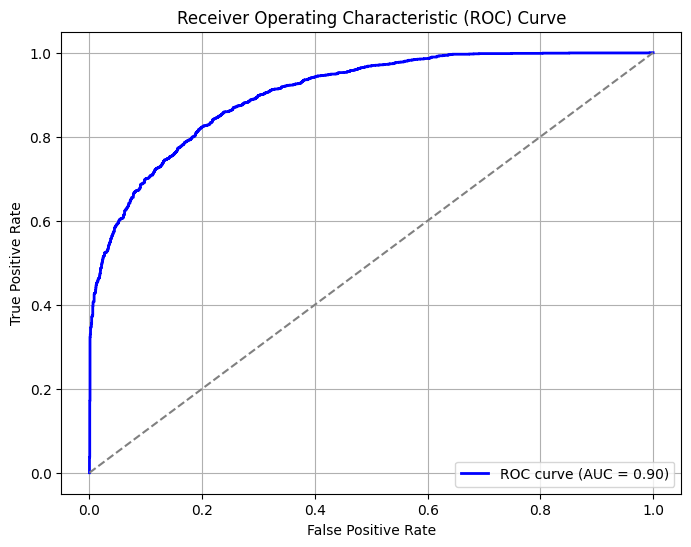

In [19]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
import shap
import matplotlib.pyplot as plt

# === DATA PREPROCESSING ===
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === HYPERPARAMETER TUNING WITH GRID SEARCH ===
param_grid = {
    'C': [0.1, 1, 10, 100],
    'max_iter': [200, 500, 1000],
    'penalty': ['l2']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy', verbose=1)
grid_search.fit(X_train, Y_train)

print("\nBest parameters:", grid_search.best_params_)
print("Best CV score:", round(grid_search.best_score_, 4))

# Train the best model
logistic_model = grid_search.best_estimator_
logistic_model.fit(X_train, Y_train)
print('Logistic Regression Trained ✅')

# === MODEL EVALUATION ===
logistic_pred = logistic_model.predict(X_test)
logistic_prob = logistic_model.predict_proba(X_test)[:, 1]

print("\nLogistic Regression Performance:")
print(classification_report(Y_test, logistic_pred))
print("Accuracy:", accuracy_score(Y_test, logistic_pred))
print("Confusion Matrix:\n", confusion_matrix(Y_test, logistic_pred))

# === CROSS-VALIDATION ===
cv_scores = cross_val_score(logistic_model, X, Y, cv=5, scoring='accuracy')
print("\nCross-Validation Scores:", cv_scores)
print("Average CV Accuracy:", round(cv_scores.mean(), 4))

# === ROC CURVE & AUC SCORE ===
fpr, tpr, _ = roc_curve(Y_test, logistic_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

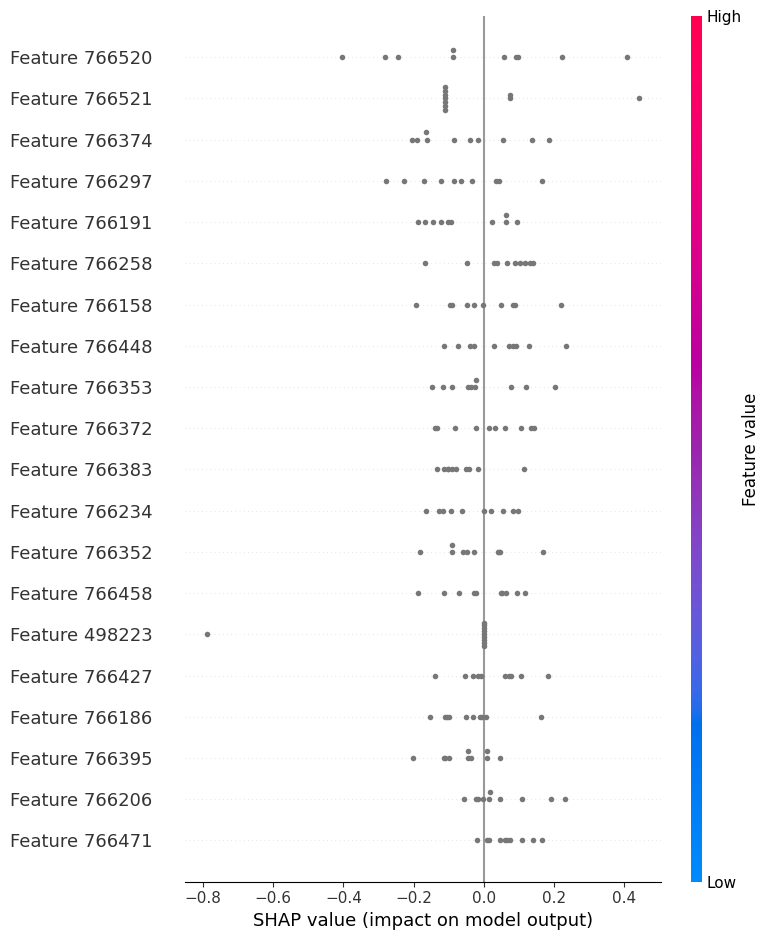

In [18]:
# Use np.random.default_rng() for reproducibility
rng = np.random.default_rng(42)

# Convert to a smaller sample using numpy random choice
sample_indices_train = rng.choice(X_train.shape[0], size=10, replace=False)
sample_indices_test = rng.choice(X_test.shape[0], size=10, replace=False)

import numpy as np
import shap

# Use np.random.default_rng() for reproducibility
rng = np.random.default_rng(42)

# Convert to a smaller sample using numpy random choice
sample_indices_train = rng.choice(X_train.shape[0], size=10, replace=False)
sample_indices_test = rng.choice(X_test.shape[0], size=10, replace=False)

X_train_sample = X_train[sample_indices_train]
X_test_sample = X_test[sample_indices_test]

# SHAP explainer with the smaller sample
explainer = shap.Explainer(logistic_model, X_train_sample)
shap_values = explainer(X_test_sample)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_test_sample)

In [29]:
# === RFC using RandomizedSearchCV ===
rf_params = {
    'n_estimators': [100],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_model = RandomizedSearchCV(
    RandomForestClassifier(n_jobs=-1, random_state=42), 
    rf_params, 
    n_iter=3, 
    cv=2, 
    scoring='accuracy', 
    n_jobs=-1, 
    verbose=1, 
    random_state=42
)

rf_model.fit(X_train, Y_train)

rf_pred = rf_model.best_estimator_.predict(X_test)
print("Random Forest Performance:")
print(classification_report(Y_test, rf_pred))


Fitting 2 folds for each of 3 candidates, totalling 6 fits
Random Forest Performance:
              precision    recall  f1-score   support

           0       0.87      0.78      0.83      2055
           1       0.79      0.88      0.83      1945

    accuracy                           0.83      4000
   macro avg       0.83      0.83      0.83      4000
weighted avg       0.83      0.83      0.83      4000



In [ ]:
# === SVM using RandomizedSearchCV ===
svm_params = {'C': np.logspace(-2, 2, 5), 'kernel': ['rbf']}
svm_model = RandomizedSearchCV(SVC(cache_size=1000), svm_params, n_iter=3, cv=2, scoring='accuracy', n_jobs=-1, random_state=42)
svm_model.fit(X_train, Y_train)
print('SVM Trained')

svm_pred = svm_model.best_estimator_.predict(X_test)
print("SVM Performance:")
print(classification_report(Y_test, svm_pred))

In [60]:
data = pd.read_csv('YouTube_Datasets/features_youtube.csv')

In [61]:
data.dropna(inplace=True)

In [62]:
def convert_embedding(embedding):
    if isinstance(embedding, np.ndarray):
        return embedding
    elif isinstance(embedding, list):
        return np.array(embedding, dtype=np.float32)
    elif isinstance(embedding, str):
        embedding = embedding.strip("[]")
        embedding = np.array([float(x) for x in embedding.split()], dtype=np.float32)
        return embedding
    else:
        return np.zeros(768, dtype=np.float32)

data['sbert_embedding'] = data['sbert_embedding'].apply(convert_embedding)

embeddings = np.stack(data['sbert_embedding'].values)

print("Embeddings Shape:", embeddings.shape)

Embeddings Shape: (667, 384)


In [63]:
faiss_index = faiss.IndexFlatL2(embeddings.shape[1])
faiss_index.add(embeddings)

In [64]:
X_bow = vectorizer.transform(data['Preprocessed_content'])
X_bow.shape

(667, 383068)

In [65]:
X_tfidf = tfidf.transform(data['Preprocessed_content'])
X_tfidf.shape

(667, 383068)

In [66]:
X = hstack([
    X_tfidf,
    X_bow,  
    embeddings,
    data[['sentiment', 'hate_speech_count', 'lexical_diversity', 'sentence_complexity']].values
])

Y = data['Label']

In [30]:
logistic_pred = logistic_model.predict(X)
print("Logistic Regression Performance:")
print(classification_report(Y, logistic_pred))

NameError: name 'logistic_model' is not defined

In [69]:
svm_pred = svm_model.predict(X_res)
print("SVM Performance:")
print(classification_report(Y_res, svm_pred))

NameError: name 'svm_model' is not defined

In [32]:
rf_pred = rf_model.predict(X_res)
print("RF Performance:")
print(classification_report(Y_res, rf_pred))

RF Performance:
              precision    recall  f1-score   support

           0       0.83      0.52      0.64       591
           1       0.65      0.89      0.75       591

    accuracy                           0.70      1182
   macro avg       0.74      0.70      0.69      1182
weighted avg       0.74      0.70      0.69      1182

